# Transfer Learning

В этом ноутбуке будет показана возможность использовать предобученные классификаторы для дальнейшего простого и быстрого их дообучения на нужной базе

### Зачем это нужно?
* Конечная база данных недостаточно представительна для полноценного обучения (сотни или даже десятки картинок)
* Имеется предобученная СНС на представительной БД (например, ImageNet)
* Нужно быстро получить классификатор на новой (конечной) БД

### Как это обычно делают в Keras?
* Берут предобученный СНС-классификатор
* Отрезают все слои, следующие за последним сверточным (Flatten, Dense, Softmax)
* Замораживают веса оставшихся слоев (опционально - для ускорения обучения)
* Сверху навешивают новую "голову" с нужным числом классов и своей функцией потерь
* Собирают (компилируют) новую модель и дообучают

### План
* Обучим сеть для MNIST
* Обучим сеть для Fashion MNIST 
* Сделаем Transfer Learning:
  * для MNIST -> Fashion MNIST
  * для Fashion MNIST -> MNIST
* Увидим, что использование этой техники даже в таком игрушечном примере может улучшать качество по сравнению с обычным обучением
* Покажем, как делать Transfer Learning для предобученных моделей на Keras 

In [2]:
import os
import numpy as np
import random
import tensorflow as tf

# for reproducibility
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)  
tf.random.set_seed(seed)

import keras
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.layers import Conv2D
 
import matplotlib.pyplot as plt

In [3]:
n_epoch_orig = 1
n_epoch_fn = 2

#### Загружаем стандартные интерфейсы для работы с (Fashion) MNIST

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

### MNIST

#### Загружаем саму базу MNIST

In [5]:
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
print(m_x_train.dtype)

uint8


In [7]:
print(m_x_train.shape, m_x_test.shape, m_y_train.shape, m_y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


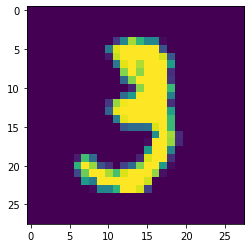

3


In [8]:
ind = 10
m_image = m_x_train[ind]
plt.imshow(m_image)
plt.show()
print(m_y_train[ind])

#### Preprocessing

In [9]:
m_x_train = m_x_train.astype(np.float32)[..., np.newaxis]/255
m_x_test = m_x_test.astype(np.float32)[..., np.newaxis]/255
m_y_train = np_utils.to_categorical(m_y_train, num_classes=10)
m_y_test = np_utils.to_categorical(m_y_test, num_classes=10)

In [10]:
print(m_x_train.shape, m_x_test.shape, m_y_train.shape, m_y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


#### Конструируем простую СНС

In [11]:
m_input_image = Input(shape=(28, 28, 1), name='m_input')
m_conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last', name='m_conv1')(m_input_image)
m_conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last', name='m_conv2')(m_conv1)
m_flatten = Flatten()(m_conv2)
m_dense1 = Dense(128, activation='relu')(m_flatten)
m_dense2 = Dense(10, activation='softmax')(m_dense1)
m_model = Model(inputs=m_input_image, outputs=m_dense2)

#### Смотрим краткую инфу по СНС

In [12]:
m_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 m_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 m_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               200832    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 211,690
Trainable params: 211,690
Non-trainable

#### Объединяем с функцией потерь, оптимизатором и набором метрик

In [13]:
m_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Обучаем

In [14]:
m_history = m_model.fit(m_x_train, m_y_train, validation_split=0.25, batch_size=32, epochs=n_epoch_orig, verbose=1)

1407/1407 [==============================] - 20s 7ms/step - loss: 0.2011 - accuracy: 0.9407 - val_loss: 0.0970 - val_accuracy: 0.9698


In [ ]:
# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()

#### Смотрим качество на тесте

In [15]:
m_score = m_model.evaluate(m_x_test, m_y_test, verbose=0)
print('MNIST acc: ', 100*m_score[1])

MNIST acc:  97.10999727249146


#### Сохраняем веса последнего сверточного слоя 'm_conv2' 
* Обращаем внимание, как обращаться к слою по имени (который можно посмотреть в model.summary() )
* Обращаем внимание, как вытаскивать обучаемые веса слоя через **get_weights**() )
* m_c[0] - ядра сверток, m_c[1] - их сдвиги

In [16]:
m_c = m_model.get_layer('m_conv2').get_weights()
print(m_c[1]) 

[-0.01445877 -0.00854254 -0.02302149 -0.02523356 -0.03862885 -0.00729594
  0.01086274 -0.00349463 -0.02318506 -0.03393083 -0.04538755 -0.01038425
 -0.00535049 -0.00323472 -0.01457396 -0.02059349 -0.00124498  0.00192401
 -0.00262612 -0.00940119 -0.02379405 -0.0237098  -0.01392191 -0.02483787
  0.02047408 -0.01020568 -0.03319516 -0.01299436 -0.01878564  0.0011681
 -0.00644115 -0.01833125]


### Fashion MNIST

Делаем все то же самое, что и для MNIST

In [17]:
(f_x_train, f_y_train), (f_x_test, f_y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


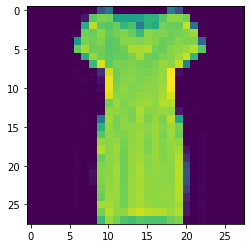

3


In [18]:
ind = 20
f_image = f_x_train[ind]
plt.imshow(f_image)
plt.show()
print(f_y_train[ind])

In [19]:
f_x_train = f_x_train.astype(np.float32)[..., np.newaxis]/255
f_x_test = f_x_test.astype(np.float32)[..., np.newaxis]/255
f_y_train = np_utils.to_categorical(f_y_train, num_classes=10)
f_y_test = np_utils.to_categorical(f_y_test, num_classes=10)

In [20]:
f_input_image = Input(shape=(28, 28, 1), name='f_input')
f_conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last', name='f_conv1')(f_input_image)
f_conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last', name='f_conv2')(f_conv1)
f_flatten = Flatten()(f_conv2)
f_dense1 = Dense(128, activation='relu')(f_flatten)
f_dense2 = Dense(10, activation='softmax')(f_dense1)
f_model = Model(inputs=f_input_image, outputs=f_dense2)

In [21]:
f_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 f_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 f_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               200832    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 211,690
Trainable params: 211,690
Non-trainab

In [22]:
f_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
f_history = f_model.fit(f_x_train, f_y_train, validation_split=0.25, batch_size=32, epochs=n_epoch_orig, verbose=1)

1407/1407 [==============================] - 10s 7ms/step - loss: 0.4706 - accuracy: 0.8315 - val_loss: 0.3715 - val_accuracy: 0.8659


In [ ]:
# Plot training & validation accuracy values
#plt.plot(fhistory.history['accuracy'])
#plt.plot(fhistory.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()

In [24]:
f_score = f_model.evaluate(f_x_test, f_y_test, verbose=0)
print('Fashion MNIST: ', 100*f_score[1])

Fashion MNIST:  86.489999294281


In [25]:
f_c = f_model.get_layer('f_conv2').get_weights()
print(f_c[1])

[ 0.09308192  0.07665817  0.01652816  0.10392188  0.00520957  0.02698178
  0.02454898  0.02927118  0.00619916  0.03640757  0.01227058  0.03283966
  0.02468068  0.07207497  0.04078242 -0.00351193  0.02065585  0.09722235
  0.08965597  0.08592422  0.03975816  0.06260531  0.00216122  0.05616238
  0.01748107  0.03483277  0.04990488  0.04573099  0.04307961  0.04654995
  0.05566308  0.04046972]


### MNIST -> Fashion MNIST  

#### Скопируем архитектуру модели MNIST (clone_model) и ее веса (set/get weights), чтобы не повредить изначальную модель

In [26]:
# скопируем модель
f2m_model = keras.models.clone_model(m_model)
f2m_model.set_weights(m_model.get_weights())
f2m_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 m_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 m_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               200832    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 211,690
Trainable params: 211,690
Non-trainable

#### Проверим, что веса скопировались

In [27]:
f2m_c = f2m_model.get_layer('m_conv2').get_weights()
print('Conv the same: ', np.all(f2m_c[0] == m_c[0]), 'Biases the same: ', np.all(f2m_c[1] == m_c[1]))

Conv the same:  True Biases the same:  True


#### Убираем последние несверточные слои
* **Внимание**: раньше можно было обращаться к .layers/._layers, теперь же приходится еще раз обертывать с Model() и напрямую указывать входы-выходы!

In [28]:
#f2m_model._layers[-3:] = []
f2m_model = Model(inputs=f2m_model.input, outputs=f2m_model.layers[-4].output)
f2m_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 m_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 m_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


#### Замораживаем сверточные слои из модели MNIST

In [29]:
for layer in f2m_model.layers:
    layer.trainable = False

#### Приделываем новую классификационную "голову"
* Для этого на вход новому слою Flatten подаем выход последнего сверточного слоя из новой модели

In [30]:
new_flatten = Flatten()(f2m_model.get_layer('m_conv2').output)
new_dense1 = Dense(128, activation='relu')(new_flatten)
new_dense2 = Dense(10, activation='softmax')(new_dense1)

new_model = Model(inputs=f2m_model.inputs, outputs=new_dense2)
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 m_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 m_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               200832    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 211,690
Trainable params: 202,122
Non-trainab

In [31]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Проверяем, что после построения новой модели веса не поменялись

In [32]:
new_c = new_model.get_layer('m_conv2').get_weights()
print('Conv the same: ', np.all(new_c[0] == m_c[0]), 'Biases the same: ', np.all(new_c[1] == m_c[1]))

Conv the same:  True Biases the same:  True


#### Дообучаем новую модель на Fashion MNIST

In [33]:
new_history = new_model.fit(f_x_train, f_y_train, validation_split=0.25, batch_size=32, epochs=n_epoch_fn, verbose=1)

Epoch 1/2
1407/1407 [==============================] - 8s 5ms/step - loss: 0.4371 - accuracy: 0.8444 - val_loss: 0.3707 - val_accuracy: 0.8673
Epoch 2/2
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3217 - accuracy: 0.8829 - val_loss: 0.3411 - val_accuracy: 0.8783


#### На всякий случай еще раз проверим, что сверточные веса были заморожены

In [34]:
new2_c = new_model.get_layer('m_conv2').get_weights()
print('Conv the same: ', np.all(new2_c[0] == m_c[0]), 'Biases the same: ', np.all(new2_c[1] == m_c[1]))

Conv the same:  True Biases the same:  True


#### Сравним качество дообученной модели с исходной

In [35]:
new_score = new_model.evaluate(f_x_test, f_y_test, verbose=0)
print('Fashion model acc =', 100*f_score[1], 'MNIST->Fashion model acc =', 100*new_score[1])

Fashion model acc = 86.489999294281 MNIST->Fashion model acc = 87.41000294685364


### Fashion MNIST -> MNIST   
* Проделаем все то же самое, только в обратном порядке

In [36]:
# скопируем модель
m2f_model = keras.models.clone_model(f_model)
m2f_model.set_weights(f_model.get_weights())
m2f_model.summary()

m2f_c = m2f_model.get_layer('f_conv2').get_weights()
print('Conv the same: ', np.all(m2f_c[0] == f_c[0]), 'Biases the same: ', np.all(m2f_c[1] == f_c[1]))

#m2f_model._layers[-3:] = []
m2f_model = Model(inputs=m2f_model.input, outputs=m2f_model.layers[-4].output)
m2f_model.summary()

for layer in m2f_model.layers:
    layer.trainable = False

new_flatten = Flatten()(m2f_model.get_layer('f_conv2').output)
new_dense1 = Dense(128, activation='relu')(new_flatten)
new_dense2 = Dense(10, activation='softmax')(new_dense1)

new_model = Model(inputs=m2f_model.inputs, outputs=new_dense2)
new_model.summary()

new_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

new_c = new_model.get_layer('f_conv2').get_weights()
print('Conv the same: ', np.all(new_c[0] == f_c[0]), 'Biases the same: ', np.all(new_c[1] == f_c[1]))

new_history = new_model.fit(m_x_train, m_y_train, validation_split=0.25, batch_size=32, epochs=n_epoch_fn, verbose=1)

new2_c = new_model.get_layer('f_conv2').get_weights()
print('Conv the same: ', np.all(new2_c[0] == f_c[0]), 'Biases the same: ', np.all(new2_c[1] == f_c[1]))

new_score = new_model.evaluate(m_x_test, m_y_test, verbose=0)
print('MNIST model acc =', 100*m_score[1], 'Fashion->MNIST model acc =', 100*new_score[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 f_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 f_conv2 (Conv2D)            (None, 7, 7, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               200832    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 211,690
Trainable params: 211,690
Non-trainab

## Работа с предобученными моделями в Keras

Для примера возьмем легкую MobileNet, все же доступные предобученные модели можно посмотреть здесь - https://keras.io/applications/

In [37]:
from keras.applications.mobilenet import MobileNet
mobile_net = MobileNet(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=1000)

17235968/17225924 [==============================] - 0s 0us/step


#### Важные параметры
* input_shape - (224,224,3) или (3, 224, 224) в зависимости от того, когда у вас идут каналы изображения (channels_last или channels_first)
* include_top=False - самый важный параметр, говорит о том, что нужно отрезать всю "голову" СНС после последней свертки
* weights='imagenet' - подгружаем веса СНС, обученной на ImageNet (classes не задаем)
* Если же хотим просто использовать архитектуру без весов, то weights=None и classes=нужное_количество

In [38]:
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

#### Заморозка слоев

In [39]:
for layer in mobile_net.layers:
    layer.trainable = False

#### Приделывание новой "головы"

In [40]:
x = mobile_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(111, activation="softmax")(x)

#### Завершение создания новой модели

In [41]:
# creating the final model 
model_final = Model(inputs = mobile_net.inputs, outputs = predictions)
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [42]:
print(keras.__version__)

2.8.0


#### Ну и дальше обучение model_final ...